# Prephase
This notebook is for conducting an analysis, no finite plots will be constructed here.

# Uploads

In [37]:
# If you are a developer, you may want to reload the packages on a fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import cooler
import pyranges as pr
from statsmodels.stats.multitest import multipletests as fdr_correction
from sklearn.feature_selection import f_classif
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
 
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns

from glob import glob
import json
from os.path import basename, splitext
from importlib import reload
import gffpandas.gffpandas as gffpd
from natsort import natsorted

import utils
from utils.anova import *
from utils.gene_intervals import bins_to_genes_intersection
from utils.plot_functions import *
from utils.hic_preproc import *
reload(utils.anova)
reload(utils.plot_functions)
reload(utils.hic_preproc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'utils.hic_preproc' from '/home/dkriukov/mice/Aging_Brain_Mice/utils/hic_preproc.py'>

In [2]:
#crucial work dirs
COOLER_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC'
DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/downsampled'
INSULATION_PATH = '/tank/projects/kriukov_chromatin/HIC/insulation'
TAD_PATH = '/tank/projects/kriukov_chromatin/HIC/tads'
LOOP_PATH = '/tank/projects/kriukov_chromatin/HIC/loops'
COMPARTMENTS_PATH = '/tank/projects/kriukov_chromatin/HIC/compartments'
GENOME_FOLDER_PATH = '/tank/projects/kriukov_chromatin/GENOME'
ATAC_FOLDER_PATH = '/tank/projects/kriukov_chromatin/ATAC'

In [55]:
#import genes
gffpath = '%s/GCF_000001635.27_GRCm39_genomic.gff' % GENOME_FOLDER_PATH
annot_path = '%s/GCF_000001635.27_GRCm39_assembly_report.txt' % GENOME_FOLDER_PATH
#refseq to chrom annotation
annotation = gffpd.read_gff3(gffpath)
fasta_annot = pd.read_csv(annot_path, sep='\t', skiprows=28)
refseq2chrom = dict(zip(fasta_annot['RefSeq-Accn'].values, fasta_annot['UCSC-style-name'].values))
gn = annotation.attributes_to_columns()
gn.seq_id = gn.seq_id.map(refseq2chrom)
gn['length'] = gn['end'] - gn['start']
gn = gn[['seq_id', 'source', 'type', 'start', 'end', 'score', 'strand',
         'ID', 'Name', 'description', 'length', 'chromosome']]

#types of sequences
gn_code = gn[gn['type']=='gene'] #protein codeing
gn_lnc = gn[gn['type']=='lnc_RNA'] #long non-coding
gn_trna = gn[gn['type']=='tRNA'] #tRNA
gn_rrna = gn[gn['type']=='rRNA'] #rRNA

In [3]:
!ls /tank/projects/kriukov_chromatin/GENOME

GCF_000001635.27_GRCm39_assembly_report.txt  chrfile.txt
GCF_000001635.27_GRCm39_genomic.fna	     chrom_arms.txt
GCF_000001635.27_GRCm39_genomic.fna.fai      data
GCF_000001635.27_GRCm39_genomic.gff


In [4]:
RESOLUTION = 250000
downsampled = False
merged = True

if downsampled:
    if merged:
        FILES = natsorted(glob('%s/merged/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))
        CLRS = [cooler.Cooler(p) for p in FILES]
    else:
        FILES = natsorted(glob('%s/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))
        CLRS = [cooler.Cooler(p) for p in FILES]
else:
    FILES = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))
    CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]

CLRS_DICT = dict(zip([basename(c.filename).split('_')[1] for c in CLRS], CLRS)) #### tmp!

#insulation score
#IS = pd.read_csv('%s/IS_25000.csv' % INSULATION_PATH, index_col=0)
IS = pd.read_csv('%s/IS_merged_50000.csv' % INSULATION_PATH, index_col=0)

#consensus peaks
ATAC = pd.read_csv('%s/consensus_peaks.mLb.clN.boolean.annotatePeaks.txt' % ATAC_FOLDER_PATH, sep='\t')

#TADs
TADS = json.load(open(TAD_PATH + '/' + 'lavaburst_tads_arkuda.json', 'r'))

#diffexpressed genes
slopes = pd.read_csv('subdata/diffexp_result.csv', index_col=0)

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Basic vizualization

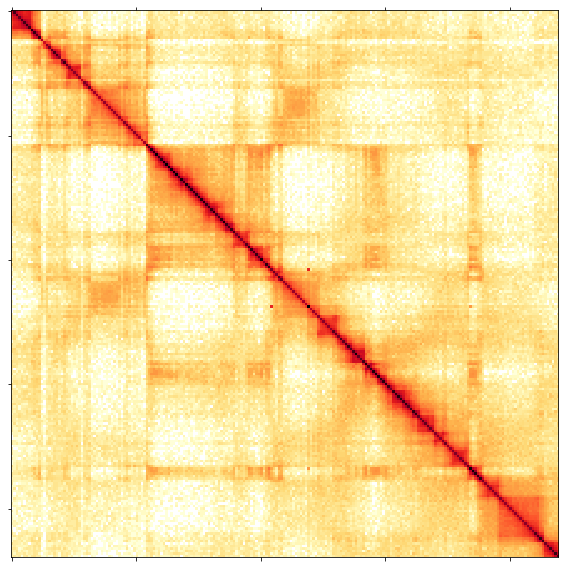

In [34]:
import cooltools
from matplotlib.colors import LogNorm
import cooltools.lib.plotting
### plot the corrected data in fall heatmap ###

clr = CLRS[0]

### to make a list of chromosome start/ends in bins:
chromstarts = []
for i in clr.chromnames:
    #print(f'{i} : {clr.extent(i)}')
    chromstarts.append(clr.extent(i)[0])

region = 'chr17:10,000,000-65,000,000'
vmax = 200
vmin = 1
#norm = LogNorm(vmin=vmin, vmax=vmax)
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

f, ax = plt.subplots(
    figsize=(8.6, 8),
    nrows=1,
    ncols=1,
    sharex=True, sharey=True)

ax.set_xticklabels([])
ax.set_yticklabels([])
im = ax.matshow(
    np.log10(clr.matrix(balance=False).fetch(region) + 1), 
    #vmax=vmax, 
    #vmin=vmin, 
    cmap='fall')
#plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, norm=norm)
#plt.xticks(chromstarts,clr.chromnames);

plt.tight_layout()
plt.savefig('figs/hic_miniature.png', dpi=300, bbox_inches='tight')

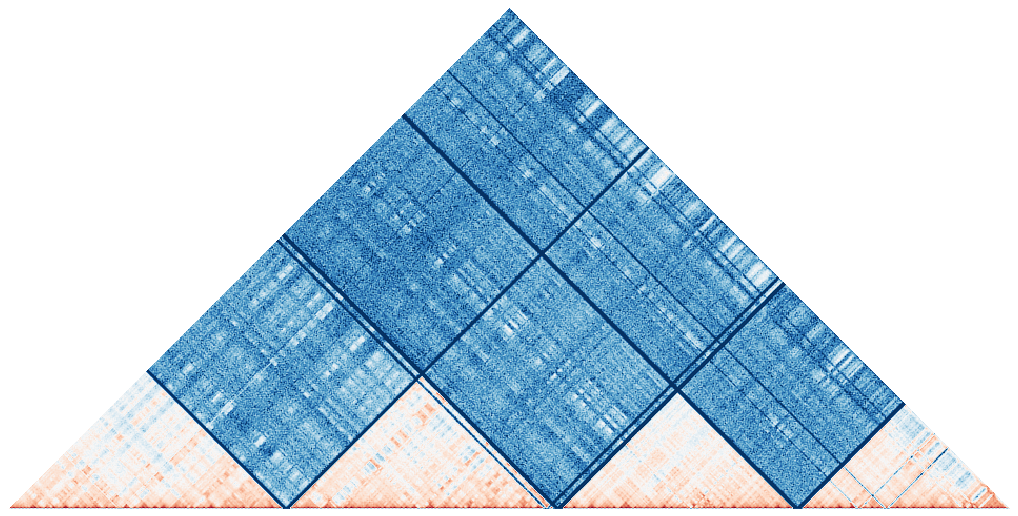

In [49]:
#large scale
pos = 155
st, fin = (pos-145, pos+530) # in bins

resolution = 1_000_000
file = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))[0]
cool = cooler.Cooler(file + "::/re
solutions/%d" % resolution)

D = cool.matrix(balance=False)[:]
D = mylog(D, log=True)
bins = cool.bins()[:]
start = bins[bins.chrom=='chr1'].index[0]

plot_hic(D, st, fin, profile=None, profnames=None, chrom_start=start)

# SCC

In [90]:
from hicrep.utils import readMcool
from hicrep import hicrepSCC
from itertools import combinations

binSize = 1_000_000 #put -1 if no .mcool
h = 1            # smoothing window half-size
dBPMax = 16_000_000 # maximal genomic distance to include in the calculation

# whether to perform down-sampling or not 
# if set True, it will bootstrap the data set # with larger contact counts to
# the same number of contacts as in the other data set; otherwise, the contact 
# matrices will be normalized by the respective total number of contacts
bDownSample = True

#paths = natsorted(glob(DOWNSAMPLED_FOLDER_PATH + '/*.cool'))
paths = FILES
# compute the SCC score
# this will result in a SCC score for each chromosome available in the data set
N = len(paths)
scc_matrix = np.zeros([N, N])
for i in tqdm(range(N)):
    for j in range(i, N):
        cool1, _ = readMcool(paths[i], binSize)
        cool2, _ = readMcool(paths[j], binSize)
        scc = hicrepSCC(cool1, cool2, h, dBPMax, bDownSample)
        scc_matrix[i,j] = np.nanmean(scc)
        scc_matrix[j,i] = np.nanmean(scc)

  0%|          | 0/12 [00:00<?, ?it/s]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/hicrep/hicrep.py:91: RuntimeWarning: invalid value encountered in double_scalars
  return rhoNan2Zero @ wsNan2Zero / wsNan2Zero.sum()
100%|██████████| 12/12 [03:30<00:00, 17.53s/it]


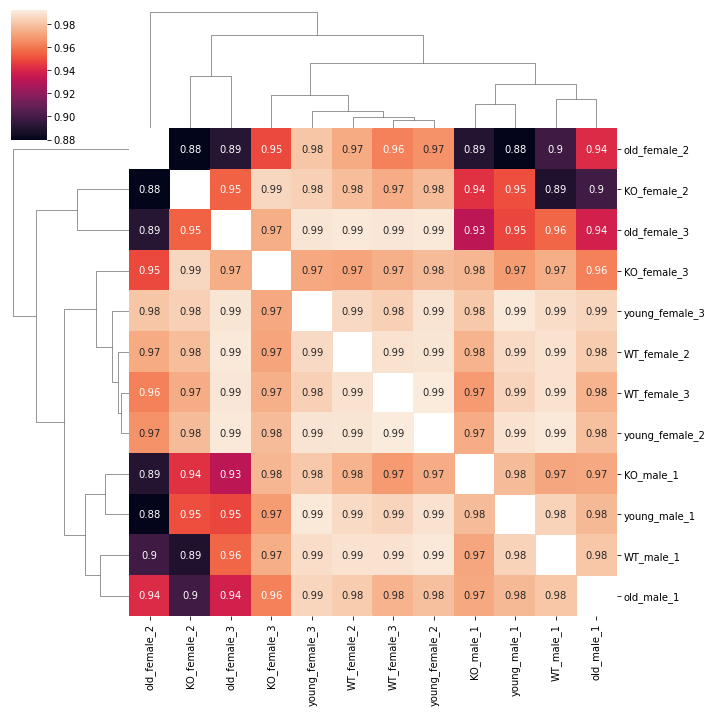

In [91]:
#add names
np.fill_diagonal(scc_matrix, 1)
scc_df = pd.DataFrame(scc_matrix, 
                      columns=[basename(path).split('.')[0] for path in paths],
                      index=[basename(path).split('.')[0] for path in paths])

sns.clustermap(scc_df, annot=True , mask=scc_df==1, method='complete')
#plt.savefig('./imgs/test.png', dpi=200)

# Scaling

In [171]:
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis
from cooltools.lib import plotting
import logging
logging.getLogger().disabled = True
sns.set_theme(font_scale=2)

# Use bioframe to fetch the genomic features from the UCSC.
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_cens = bioframe.fetch_centromeres('mm10')
mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
mm10_arms = mm10_arms.set_index("chrom").loc[CLRS[0].chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
mm10_arms = bioframe.make_viewframe(mm10_arms)

In [180]:
#construct scalings
scalings_data = {}
for cond, clr in CLRS_DICT.items():
    # Calculate expected interactions for chromosome arms
    expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
    scalings_data[cond] = expected


In [225]:
scalings_data['KO']

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg
0,chr1_p,chr1_p,0,3808,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1_p,chr1_p,1,3788,NaN,NaN,NaN,NaN,0.000248,0.000248
2,chr1_p,chr1_p,2,3785,700182.0,88.034911,184.988639,0.023259,0.021903,0.021971
3,chr1_p,chr1_p,3,3782,511915.0,64.509630,135.355632,0.017057,0.016591,0.016570
4,chr1_p,chr1_p,4,3779,406068.0,51.520797,107.453824,0.013633,0.013261,0.013180
...,...,...,...,...,...,...,...,...,...,...
54515,chrY_p,chrY_p,1830,0,0.0,0.000000,NaN,NaN,0.000722,0.000059
54516,chrY_p,chrY_p,1831,0,0.0,0.000000,NaN,NaN,0.000722,0.000059
54517,chrY_p,chrY_p,1832,0,0.0,0.000000,NaN,NaN,0.000722,0.000059
54518,chrY_p,chrY_p,1833,0,0.0,0.000000,NaN,NaN,0.000722,0.000059


In [242]:
#aggregate expected data
column = 'count.sum'
log = False
scale = 'mb'

agg_scaling = pd.DataFrame()
for k in scalings_data.keys():
    if column in ['count.sum', 'balanced.sum']:
        s = scalings_data[k].groupby('dist').mean()[column]
    else:
        raise NotImplementedError
    if log:
        s = np.log10(s)
    agg_scaling[k] = s

if scale == 'kb':
    agg_scaling.index = clr.info['bin-size'] * np.arange(agg_scaling.shape[0]) // 1000 
elif scale == 'mb':
    agg_scaling.index = clr.info['bin-size'] * np.arange(agg_scaling.shape[0]) / 1_000_000 

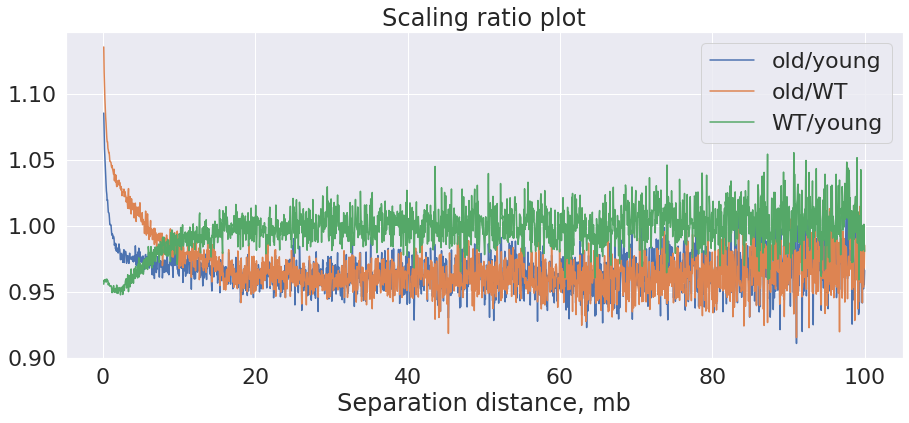

In [262]:
max_dist = 100
pairs = [['old', 'young'], ['old', 'WT'], ['WT', 'young']]
plt.figure(figsize=(15,6))
plt.title('Scaling ratio plot')
plt.xlabel(f'Separation distance, {scale}')
for pair in pairs:
    tmp = agg_scaling[agg_scaling.index <= max_dist]
    rel = tmp[pair[0]] / tmp[pair[1]]
    plt.plot(rel, label = f'{pair[0]}/{pair[1]}')
plt.legend()
plt.show()

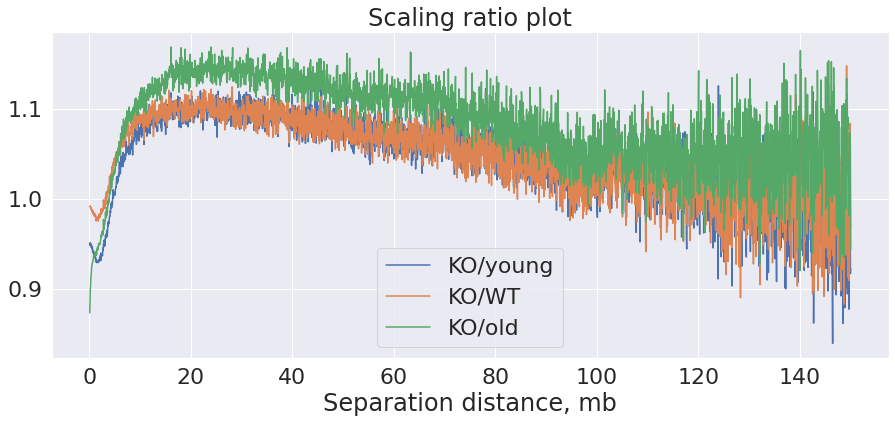

In [263]:
max_dist = 150
pairs = [['KO', 'young'], ['KO', 'WT'], ['KO', 'old']]
plt.figure(figsize=(15,6))
plt.title('Scaling ratio plot')
plt.xlabel(f'Separation distance, {scale}')
for pair in pairs:
    tmp = agg_scaling[agg_scaling.index <= max_dist]
    rel = tmp[pair[0]] / tmp[pair[1]]
    plt.plot(rel, label = f'{pair[0]}/{pair[1]}')
plt.legend()
plt.show()

# Intra/Interchromosomal interactions

In [68]:
def compute_cis_trans(hiclist, dropdiag=2, resolution=100000, stable=True, normalized=False):
    """
    This function returns a dictionary where keys are names of Hi-C matrices
    and values are matrices of cis-trans contact sums.
    
    hiclist :: [str] - list of paths to .mcool files
    dropdiag :: int - number of diags to drop (main diagonal counts from 1)
    resolution :: int - desired resolution for Hi-C matrix
    stable :: bool - whether to add 1 to contact sums matrix (for numerical 
                     stability at logarithm computation)
    normalized :: bool - whether to normalize matrix with a total sum of contacts
    """
    interchrom = {}
    for path in tqdm(hiclist):
        #clr = cooler.Cooler(path + '::/resolutions/%d' % resolution)
        clr = cooler.Cooler(path)
        sizes = np.array(clr.chromsizes.values) / resolution #compute normalization matrix
        norm = np.outer(sizes, sizes)

        pix = clr.pixels()[:]
        pix_no_diag = pix[pix.bin2_id >= pix.bin1_id + dropdiag] #delete m first diagonals
        bins = clr.bins()[:].drop(['start', 'end'], 1)

        cis_trans = np.asarray(
                    pix_no_diag.merge(bins, left_on='bin1_id', right_index=True).\
                                merge(bins, left_on='bin2_id', right_index=True).\
                                groupby(['chrom_x', 'chrom_y']).sum().\
                                unstack(fill_value=0)['count']) #convert to square matrix

        cis_trans = cis_trans + cis_trans.T - np.diag(np.diag(cis_trans))
        if normalized:
            fullsum = np.nansum(cis_trans)
            if fullsum == 0.:
                print('Drop %s due to zero contact sum' % path)
                continue
            cis_trans = cis_trans / fullsum * 2 * 1_000_000 #scale by constant
        if stable:
            cis_trans += 1
        result = cis_trans / norm
        interchrom[splitext(basename(clr.filename))[0]] = result
    return interchrom

In [153]:
interactions = compute_cis_trans(FILES, dropdiag=0, resolution=50000, stable=True, normalized=False)

100%|██████████| 4/4 [02:20<00:00, 35.03s/it]


In [154]:
interactions = dict(zip([k.split('_')[1] for k in interactions.keys()], interactions.values()))
chroms = CLRS[0].chromnames

In [155]:
[(k, v.sum()) for k,v in interactions.items()]

[('KO', 51.7190138378333),
 ('WT', 52.229652566591696),
 ('old', 51.403358991520065),
 ('young', 52.04233557883741)]

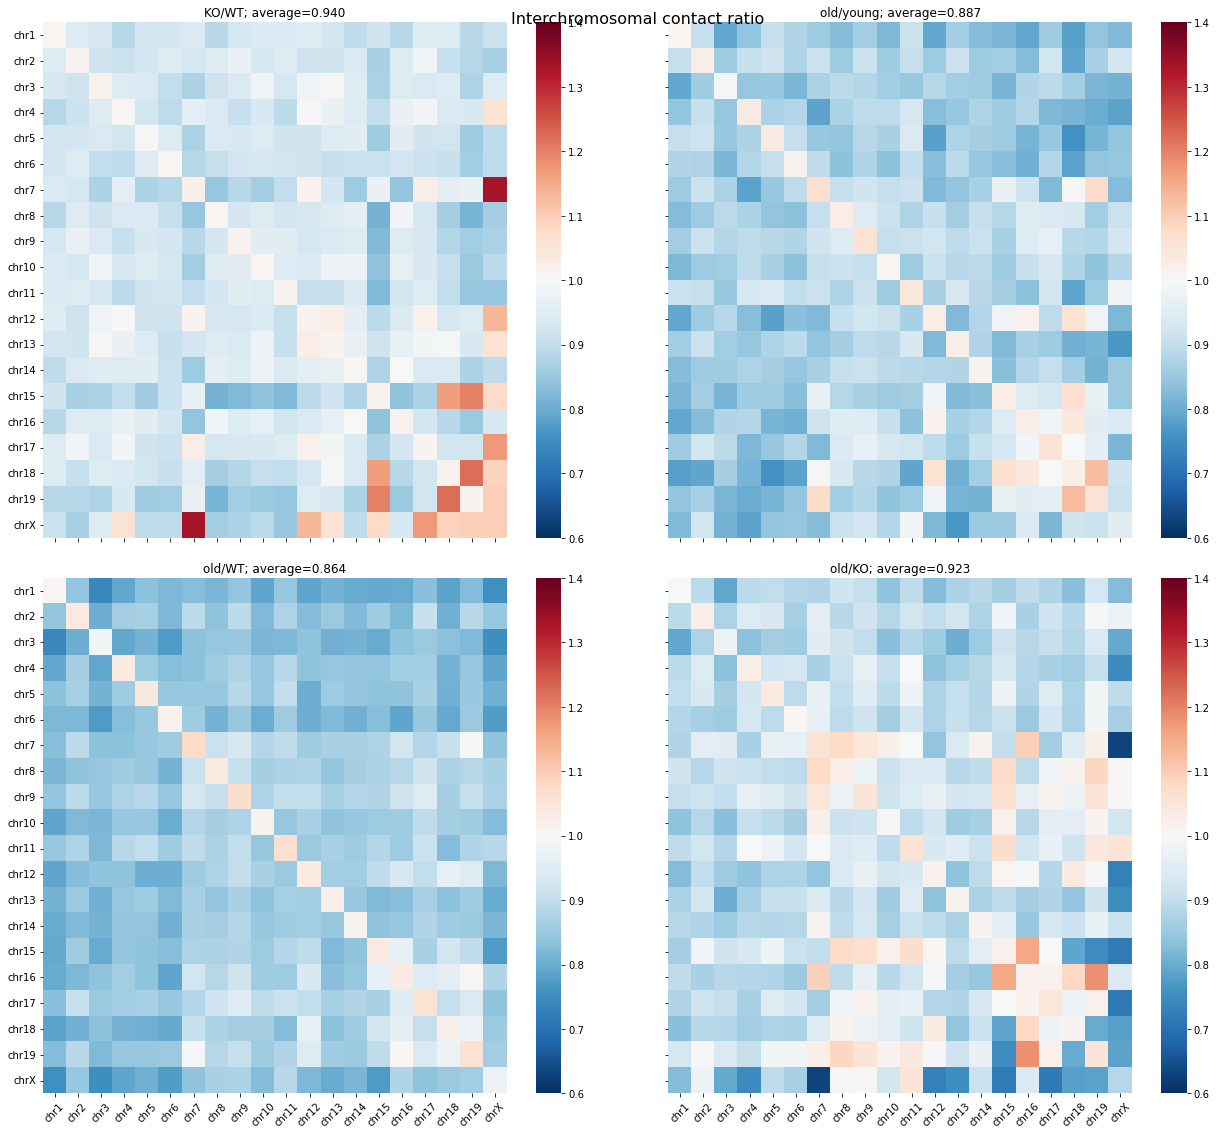

In [159]:
pairs = [('KO', 'WT'), ('old', 'young'), ('old', 'WT'), ('old', 'KO')]
fig, axes = plt.subplots(2, 2, figsize=(18, 16), sharey=True, sharex=True)
fig.suptitle('Interchromosomal contact ratio', fontsize=16)
fig.tight_layout(pad=3)
for k, ax, pair in zip(interactions.keys(), axes.flatten(), pairs):
    map1 = interactions[pair[0]][:-1, :-1]
    map2 = interactions[pair[1]][:-1, :-1]
    m = map1 / map2
    #np.fill_diagonal(m, np.nan)
    ax.set_title(pair[0] + '/' + pair[1] + '; average=%.3f' % np.nanmean(m))
    sns.heatmap(m, cmap='RdBu_r', ax=ax, vmax=1.4, vmin=0.6)
    ax.set_xticklabels(chroms[:-1], rotation=45)
    ax.set_yticklabels(chroms[:-1], rotation=0)


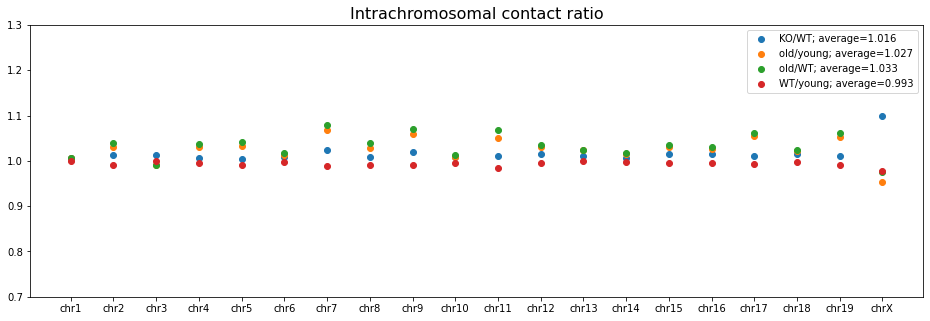

In [157]:
pairs = [('KO', 'WT'), ('old', 'young'), ('old', 'WT'), ('WT', 'young')]

plt.figure(figsize=(16,5))
plt.title('Intrachromosomal contact ratio', fontsize=16)
for k, ax, pair in zip(interactions.keys(), axes.flatten(), pairs):
    map1 = interactions[pair[0]][:-1, :-1].diagonal()
    map2 = interactions[pair[1]][:-1, :-1].diagonal()
    m = map1 / map2
    plt.scatter(chroms[:-1], m, label=pair[0] + '/' + pair[1] + '; average=%.3f' % np.nanmean(m))
plt.legend()
plt.ylim([0.7, 1.3])
plt.show()
    #ax.set_yticklabels(chroms[:-1], rotation=0)


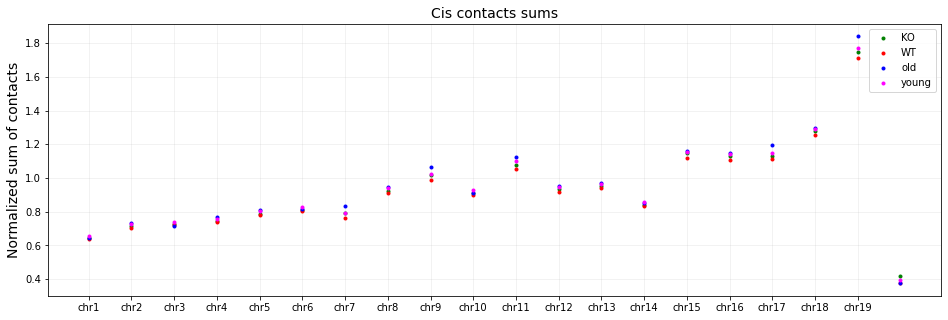

In [147]:
colors = ['green'] + ['red'] + ['blue'] + ['magenta']
#colors = ['red']*2 + ['green']*2

analysis_type = 'c' #c #t #ct

plt.figure(figsize=(16,5))
values = {}
for i, k in enumerate(list(interactions.keys())):
    map = interactions[k][:-1, :-1]
    if analysis_type == 'c':
        f = map.diagonal(0)
        plt.title('Cis contacts sums', fontsize=14)
    elif analysis_type == 't':
        f = (map.sum(1)- map.diagonal(0))
        plt.title('Trans contacts sums', fontsize=14)
    else:
        f = map.diagonal(0) / (map.sum(1) - map.diagonal(0))
        plt.title('Cis-trans ratio', fontsize=14)
    values[k] = f
    plt.plot(f, label=k, lw=0., marker='.', color=colors[i])
    #plt.ylim([0.2, 0.5])
plt.ylabel('Normalized sum of contacts', fontsize=14)
plt.xticks(ticks=range(len(chroms[:-2])), labels=chroms[:-2])
#plt.legend(['Old', 'Old', 'Young', 'Young'])
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# Insulation score analysis

In [99]:
from scipy.signal import argrelextrema
import scipy.optimize as optimization

explore = ['WT', 'young', 'old', 'KO']
mask = np.array([any([e in c for e in explore]) for c in IS.columns])

X = IS.drop(IS.columns[~mask], 1).T
#X = X.dropna(axis=1)

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


## Age dependence analysis

In [100]:
X = X.dropna(axis=1)

In [177]:
y = [4, 10, 20]
x_labels = ['young', 'WT', 'old']
y_dic = dict(zip(x_labels, y))

mask = np.array([any([e in c for e in x_labels]) for c in X.index])
X1 = X.loc[mask]
age = [y_dic[y] for y in [x.split('_')[0] for x in X1.index]]

import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
from scipy.stats import pearsonr
pvals = []
coefs = []
for i in tqdm(range(X1.shape[1])):
    x = X1.iloc[: ,i]
#     X2 = sm.add_constant(x)
#     est = sm.OLS(age, X2)
#     est2 = est.fit()
#     res = est2.summary()
    r, p = pearsonr(x, age)
#     p = float(res.tables[1].data[2][4])
    pvals.append(p)
    coefs.append(r)

#model = ElasticNet()
#model.fit(X1, age)

100%|██████████| 42953/42953 [00:05<00:00, 7699.55it/s]


(array([2.0000e+00, 5.0000e+00, 1.9000e+01, 6.1000e+01, 1.9900e+02,
        5.8100e+02, 2.1140e+03, 6.1410e+03, 1.3242e+04, 2.0589e+04]),
 array([-5.25071925e+00, -4.72565544e+00, -4.20059163e+00, -3.67552782e+00,
        -3.15046401e+00, -2.62540020e+00, -2.10033639e+00, -1.57527258e+00,
        -1.05020877e+00, -5.25144961e-01, -8.11513498e-05]),
 <a list of 10 Patch objects>)

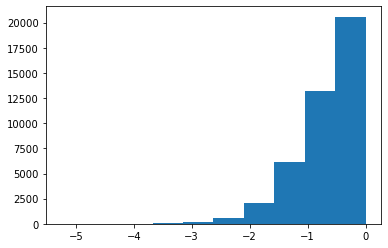

In [182]:
plt.hist(np.log10(pvals))

[0.7493108474554405,
 0.733576126102434,
 0.5754191113322994,
 0.4209875654787694,
 0.36465339028096705,
 0.3017419310912441,
 0.2752339789457133,
 0.2559911254749426,
 0.1311581342109487,
 0.23690627378239368,
 -0.06462124737979696,
 0.16770891476384236,
 0.046521489693522815,
 0.18810718656815653,
 0.09996865651707088,
 -0.05518631984592269,
 -0.5630990377824436,
 -0.4693983263575192,
 -0.5463927798793315,
 -0.4245681217862233,
 -0.14212748692659036,
 0.03813948374890373,
 0.2501492699441015,
 0.3985034779135772,
 0.4154319630130277,
 0.6786069218167993,
 0.6589514715741831,
 0.6172001641567515,
 0.5369736350356108,
 0.6070451115712505,
 0.5378262758356572,
 0.6433884124876709,
 0.6997720119712921,
 0.6069477075325399,
 0.45987747829175557,
 0.6322771261032224,
 0.565994603913158,
 0.41818331473714804,
 0.2697110172740341,
 0.12981784071709604,
 0.16776431784966214,
 0.05814452098128662,
 0.06619961068413215,
 -0.05932611744512982,
 -0.19432201288517484,
 -0.17846372183013273,
 -0.10

(array([ 483., 2941., 5594., 5697., 5019., 4575., 5114., 6810., 5537.,
        1183.]),
 array([-0.97737087, -0.78350638, -0.5896419 , -0.39577741, -0.20191292,
        -0.00804843,  0.18581606,  0.37968055,  0.57354503,  0.76740952,
         0.96127401]),
 <a list of 10 Patch objects>)

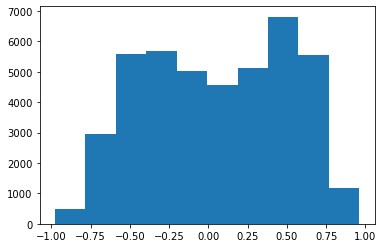

In [ ]:
plt.hist(coefs)

## TAD shift analysis

In [93]:
order = 5
indices = []
for i in range(X.shape[0]):
    row = X.iloc[i,:]
    s = np.array(row)
    lm = argrelextrema(s, np.less, order=order)[0]
    indices.append(row.iloc[lm].index)

result = sorted(list(set(indices[0]).intersection(*indices)))
border_dict = dict(zip(list(X.index), indices))

In [94]:
convex_dict = {}
for key in border_dict.keys():
    b = border_dict[key]
    convex_dict[key] = {}
    for i in range(b.shape[0]):
        x = np.arange(-order, order+1)
        v = X.loc[key, b[i]-order:b[i]+order] #vicinity of minimum
        y = v.to_numpy()

        def func(x, a):
            return a*(x**2) + y[y.shape[0]//2]

        params, _ = optimization.curve_fit(func, x, y)
        convex_dict[key][b[i]] = params.item()
    

# plt.scatter(x, y, marker='o', c='red')
# plt.plot(x, func(x, params), c='black')
# plt.show()

In [135]:
border_dict.keys()

dict_keys(['combined_KO_down_50000', 'combined_WT_down_50000', 'combined_old_down_50000', 'combined_young_down_50000'])

37449

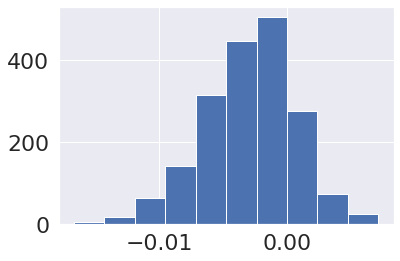

In [98]:
test = border_dict['combined_KO_down_50000'].intersection(border_dict['combined_WT_down_50000']).tolist()


diff = []
for t in test:
    d = convex_dict['combined_KO_down_50000'][t] - convex_dict['combined_WT_down_50000'][t]
    diff.append(d)

plt.hist(diff)
test[np.argmin(diff)]

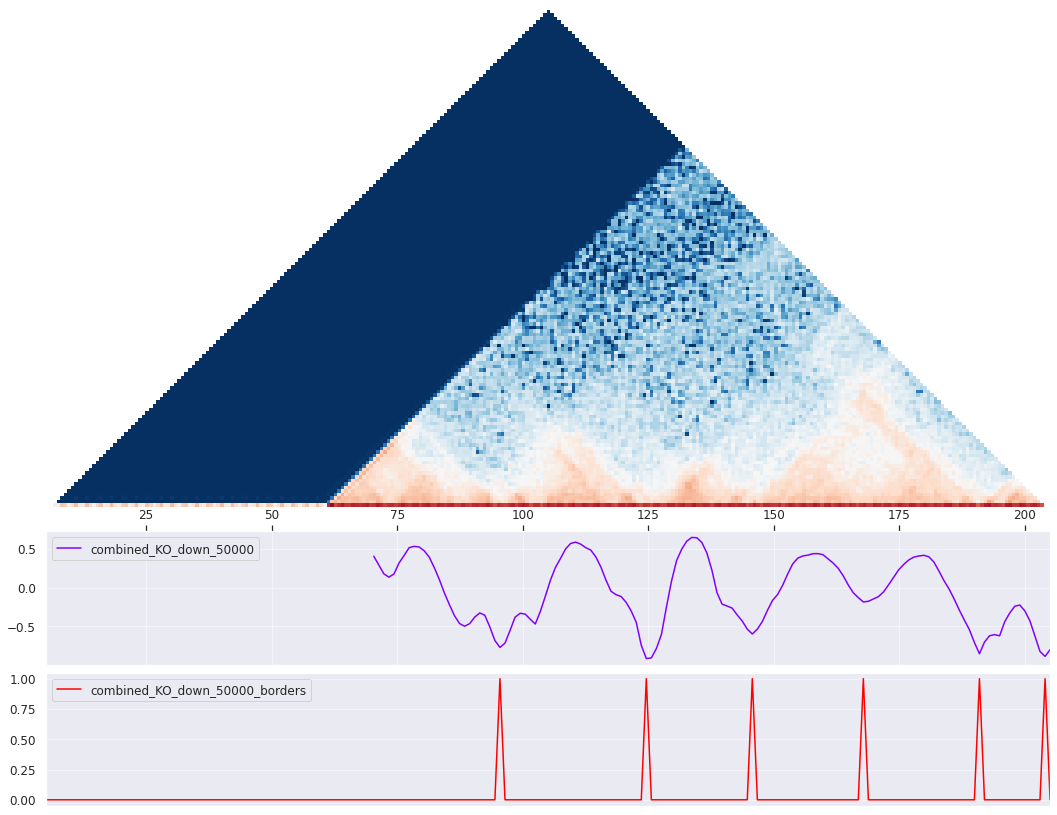

In [100]:
pos = 105
st, fin = (pos-100, pos+100) # in bins

rep = 'combined_KO_down_50000'

assert len(IS.loc[st:fin].chrom.unique()) == 1, 'choose one chromosome interval'
chrom = IS.loc[st:fin].chrom.unique()[0]

#HI-C
cool = [c for c in CLRS if c.filename.__contains__(rep)][0]
D = cool.matrix(balance=True).fetch(chrom)
D = mylog(D, log=True)
bins = cool.bins()[:]
start = bins[bins.chrom==chrom].index[0]
#IS
profile = np.array(IS[rep])#.loc[st:fin-1])
#TAD BORDERS
borders_plot = np.zeros(profile.shape)
for idx in border_dict[rep]:
    borders_plot[idx] += 1

plot_hic(D, st, fin, profile=[profile, borders_plot], 
                         profnames=[rep, rep + '_borders'], chrom_start=start)

In [15]:
# rep = 'young_male_1'

# assert len(IS.loc[st:fin].chrom.unique()) == 1, 'choose one chromosome interval'
# chrom = IS.loc[st:fin].chrom.unique()[0]

# #HI-C
# cool = [c for c in CLRS if c.filename.__contains__(rep)][0]
# D = cool.matrix(balance=True).fetch(chrom)
# D = mylog(D, log=True)
# bins = cool.bins()[:]
# start = bins[bins.chrom==chrom].index[0]
# #IS
# profile = np.array(IS[rep])#.loc[st:fin-1])
# #TAD BORDERS
# borders_plot = np.zeros(profile.shape)
# for idx in border_dict[rep]:
#     borders_plot[idx] += 1

# plot_hic(D, st, fin, profile=[profile, borders_plot], 
#                          profnames=[rep, rep + '_borders'], chrom_start=start)

## insulation peaks fold change

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KO v.s. WT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.040e-04 U_stat=6.462e+06
old v.s. young: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.111e+06
WT v.s. young: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.029e+06
KO v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.092e-03 U_stat=6.379e+06


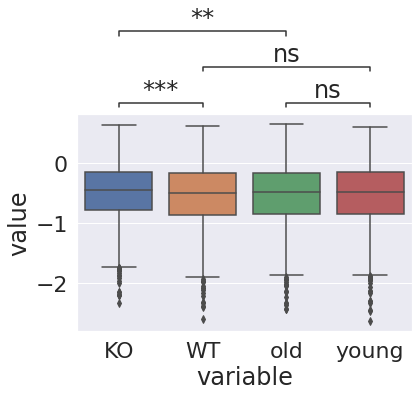

In [184]:
from functools import reduce
union = reduce(pd.Index.union, border_dict.values())

bpeaks = IS.loc[union]
tmp = pd.melt(bpeaks.iloc[:, 1:5])
tmp['variable'] = tmp['variable'].apply(lambda x: x.split('_')[1])
#for pair in 
#d = bpeaks.filter(regex='KO').iloc[:, 0] - bpeaks.filter(regex='WT').iloc[:, 0]
#d.plot(kind='kde')

from statannot import add_stat_annotation

df = sns.load_dataset("tips")
x = "variable"
y = "value"
order = ['KO', 'WT', 'old', 'young']
ax = sns.boxplot(data=tmp, x=x, y=y, order=order)
test_results = add_stat_annotation(ax, data=tmp, x=x, y=y, order=order,
                                   box_pairs=[("KO", "WT"), ("old", "young"), ("WT", "young"), ("KO", "old")],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)

## interTADs

In [5]:
#coolpuppy API
# import libraries for biological data analysis
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis
from cooltools.lib import plotting
import logging
logging.getLogger().disabled = True
sns.set_theme(font_scale=2)

# Use bioframe to fetch the genomic features from the UCSC.
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_cens = bioframe.fetch_centromeres('mm10')
mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
mm10_arms = mm10_arms.set_index("chrom").loc[CLRS[0].chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
mm10_arms = bioframe.make_viewframe(mm10_arms)

In [23]:
mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)
mm10_arms = mm10_arms.set_index("chrom")

In [24]:
mm10_chromsizes.to_csv('/tank/projects/kriukov_chromatin/GENOME/chrfile.txt', sep='\t')
mm10_arms.to_csv('/tank/projects/kriukov_chromatin/GENOME/chrom_arms.txt', sep='\t')

In [107]:
#construct average interTADs
pup = pd.DataFrame()
cond = [basename(c.filename).split('_')[1] for c in CLRS]
for k, v in border_dict.items():
    clr = [c for c in CLRS if c.filename.__contains__(k)][0]
    name = splitext(basename(clr.filename))[0]
    sites = IS.loc[v.tolist(),['chrom', 'start', 'end']].reset_index(drop=True)
    # Calculate expected interactions for chromosome arms
    expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
    #calculate mean interTADs
    cc = coolpup.CoordCreator(sites, resolution=RESOLUTION, 
                              features_format='bed', local=True, flank=1_000_000)
    pu = coolpup.PileUpper(clr, cc, expected=expected, view_df=mm10_arms, ignore_diags=0)
    pup = pup.append(pu.pileupsWithControl(nproc=18))
pup['condition'] = cond
#pup['id'] = [basename(c.filename).split('_')[1] + '_' + basename(c.filename).split('_')[2].split('.')[0] for c in CLRS]

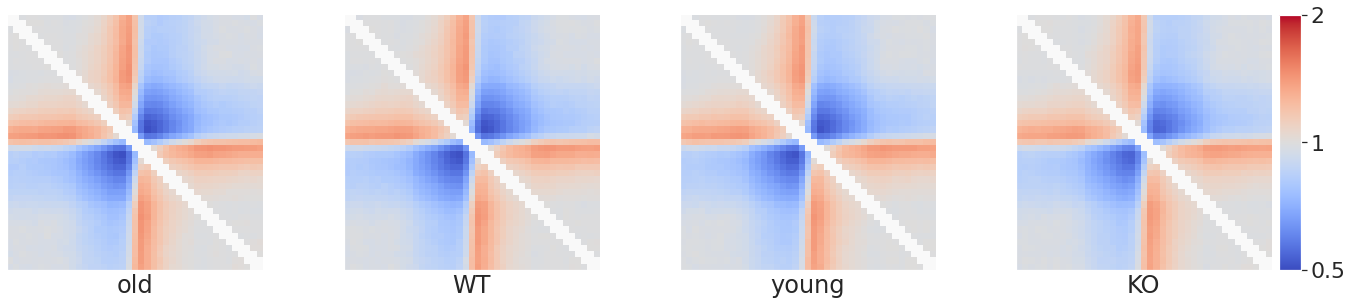

In [114]:
plotpup.make_heatmap_grid(pup,
                          #rows='condition', #col_order=['--', '++'],
                          cols='condition',
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=2,
                          height=5)

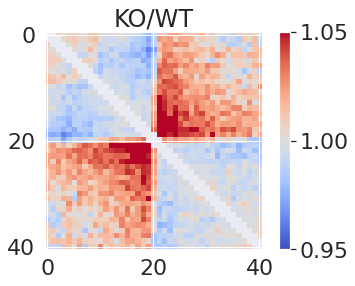

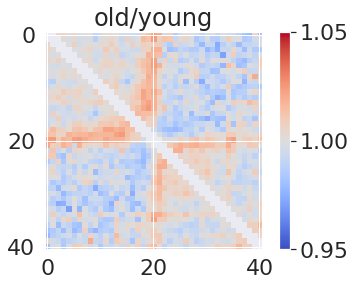

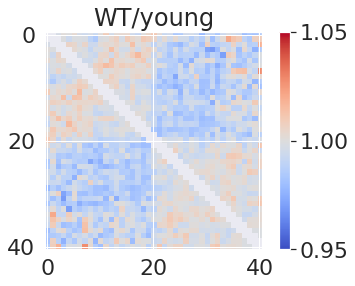

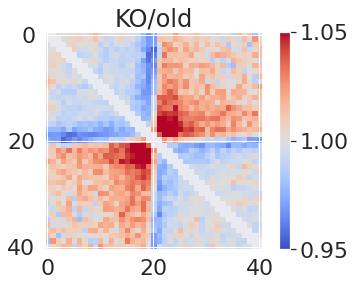

In [122]:
pairs = [['KO', 'WT'], ['old', 'young'], ['WT', 'young'], ['KO', 'old']]
for pair in pairs:
    divv = pup[pup.condition==pair[0]]['data'][0] / pup[pup.condition==pair[1]]['data'][0]
    plt.imshow(divv, interpolation='None', cmap='coolwarm', vmax=1.05, vmin=0.95)
    plt.title('%s/%s' % (pair[0], pair[1]))
    plt.colorbar()
    plt.show()

# TADs

### find TADs

In [4]:
#!pip install git+https://github.com/nvictus/lavaburst.git

#import lavaburst

#coolpuppy API
# import libraries for biological data analysis
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis
from cooltools.lib import plotting
import logging
logging.getLogger().disabled = True
sns.set_theme(font_scale=2)

# Use bioframe to fetch the genomic features from the UCSC.
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_cens = bioframe.fetch_centromeres('mm10')
mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
mm10_arms = mm10_arms.set_index("chrom").loc[CLRS[0].chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
mm10_arms = bioframe.make_viewframe(mm10_arms)

In [68]:
#construct average TADs
ids_10k = cooler.Cooler(DOWNSAMPLED_FOLDER_PATH + '/merged/combined_KO_down_10000.cool').bins()[:]
base_expected = False #CLRS_DICT['WT']
minimal_tad_size = 1_000_000
maximal_tad_size = np.inf

pup = pd.DataFrame()
for cond, clr in CLRS_DICT.items():
    name = splitext(basename(clr.filename))[0]
    #gather tad coordinates
    tad_name = [c for c in list(TADS.keys()) if c.__contains__(cond)][0]
    tads = TADS[tad_name]
    sites = pd.DataFrame()
    for chrom in tads.keys():
        tads[chrom]
        for t in tads[chrom]:
            st = ids_10k[ids_10k['chrom']==chrom].iloc[t[0]]['start']
            en = ids_10k[ids_10k['chrom']==chrom].iloc[t[1]]['end']
            sites = sites.append({'chrom':chrom, 'start':st, 'end':en}, ignore_index=True)
    sites['start'] = sites['start'].astype(int)
    sites['end'] = sites['end'].astype(int)
    #sites = sites.head(1)
    sites = sites[((sites['end'] - sites['start']) > minimal_tad_size) &\
                  ((sites['end'] - sites['start']) < maximal_tad_size)]
    # Calculate expected interactions for chromosome arms
    if base_expected:
        expected = expected_cis(base_expected, view_df=mm10_arms, chunksize=1000000, nproc=18)
    else:
        expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
    #calculate mean interTADs
    cc = coolpup.CoordCreator(sites, resolution=RESOLUTION, 
                              features_format='bed', local=True, rescale_flank=0.5)
    pu = coolpup.PileUpper(clr, cc, 
                           expected=expected, 
                           rescale=True,
                           view_df=mm10_arms, ignore_diags=0)
    pup = pup.append(pu.pileupsWithControl(nproc=18))
pup['condition'] = CLRS_DICT.keys()


/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Ignoring flank in favor of rescale_flank = 0.5
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Ignoring flank in favor of rescale_flank = 0.5
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Ignoring flank in favor of rescale_flank = 0.5
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Ignoring flank in favor of rescale_flank = 0.5


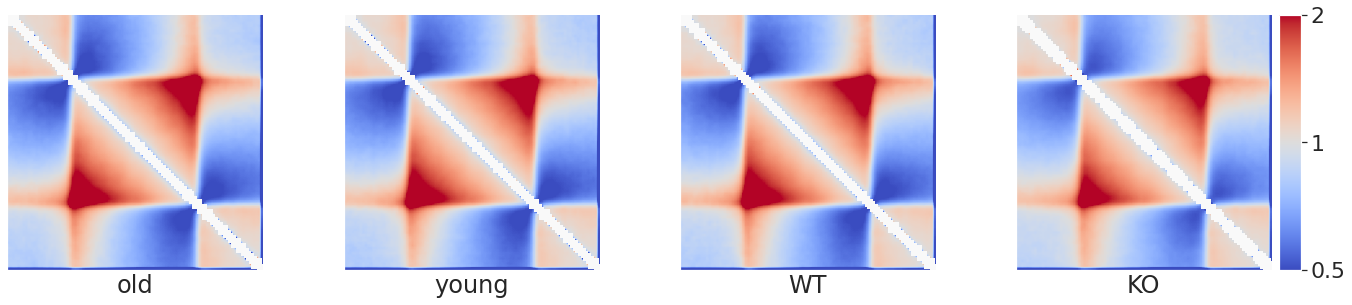

In [69]:
plotpup.make_heatmap_grid(pup,
                          #rows='condition', #col_order=['--', '++'],
                          cols='condition',
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=2,
                          height=5)

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


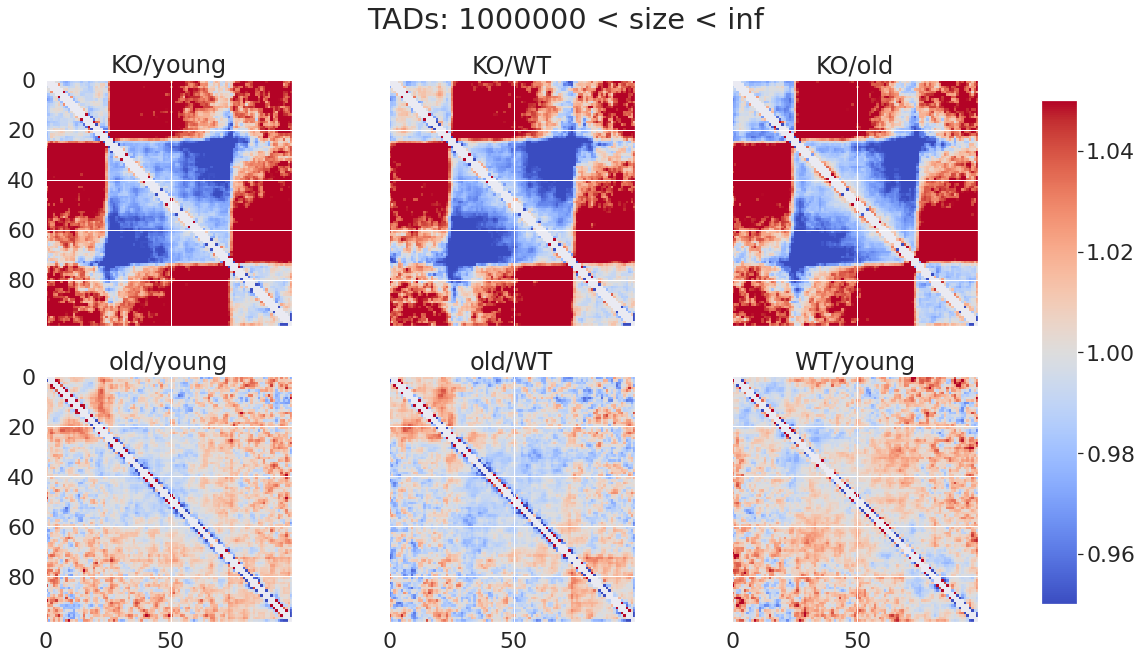

In [70]:
pairs = [['KO', 'young'], ['KO', 'WT'], ['KO', 'old'], ['old', 'young'], ['old', 'WT'], ['WT', 'young']]

fig, axes = plt.subplots(2, round(len(pairs)/2), figsize=(5 * (len(pairs)//2 + 1), 10), sharex=True, sharey=True)
fig.suptitle(f'Average TADs: {minimal_tad_size} < size < {maximal_tad_size}')
for pair, ax in zip(pairs, axes.flatten()):
    divv = pup[pup.condition==pair[0]]['data'][0] / pup[pup.condition==pair[1]]['data'][0]
    img = ax.imshow(divv, interpolation='None', cmap='coolwarm', vmax=1.05, vmin=0.95)
    ax.set_title('%s/%s' % (pair[0], pair[1]))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.025, 0.7])
fig.colorbar(img, cax=cbar_ax)
if len(pairs) % 2 != 0: #remove redundant axis
    axes.flatten()[-1].set_axis_off()
plt.show()

In [59]:
####plot average TADs by IS
# #construct average TADs
# pup = pd.DataFrame()
# cond = [basename(c.filename).split('_')[0] for c in CLRS]
# for k, v in border_dict.items():
#     clr = [c for c in CLRS if c.filename.__contains__(k)][0]
#     name = splitext(basename(clr.filename))[0]
#     #assumption: TADs are not intermittent
#     sites = IS.loc[v.tolist(),['chrom', 'start', 'end']].reset_index(drop=True)
#     sites['end'] = np.roll(sites['end'], -1)
#     sites = sites[:-1]
#     #sites = sites.head(1)
#     # Calculate expected interactions for chromosome arms
#     expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
#     #calculate mean interTADs
#     cc = coolpup.CoordCreator(sites, resolution=RESOLUTION, 
#                               features_format='bed', local=True, flank=1_000_000)
#     pu = coolpup.PileUpper(clr, cc, 
#                            #expected=expected, 
#                            rescale=True,
#                            view_df=mm10_arms, ignore_diags=0)
#     pup = pup.append(pu.pileupsWithControl(nproc=18))
# pup['condition'] = cond
# pup['id'] = [basename(c.filename).split('_')[1] + '_' + basename(c.filename).split('_')[2].split('.')[0] for c in CLRS]

# Loops

In [91]:
import os
#Run loops finding
min_dist = 350_000
max_dist = 3_500_000
pearson = 0.45
for clr in tqdm(CLRS):    
    cool = clr.filename
    prefix = LOOP_PATH + '/' + splitext(basename(cool))[0]
    command = f"chromosight detect --threads 24 \
        --min-dist {min_dist} --max-dist {max_dist} --pearson {pearson} \
        {cool} {prefix}"
    os.system(command)


  0%|          | 0/4 [00:00<?, ?it/s]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [===-----------------] 14.3% chr4-chr4

Found 49386 / 54520 detectable bins


 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Sub matrices extracted


 [====================] 100.0% Kernel: 0, Iteration: 0


Minimum pattern separation is : 1


2967 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_KO_down_50000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_KO_down_50000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_KO_down_50000.pdf
 25%|██▌       | 1/4 [00:12<00:37, 12.43s/it]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [===-----------------] 14.3% chr4-chr4

Found 49462 / 54520 detectable bins


 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Sub matrices extracted


 [====================] 100.0% Kernel: 0, Iteration: 0


Minimum pattern separation is : 1


3068 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_WT_down_50000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_WT_down_50000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_WT_down_50000.pdf
 50%|█████     | 2/4 [00:25<00:25, 12.68s/it]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [===-----------------] 14.3% chr4-chr4

Found 49762 / 54520 detectable bins


 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Sub matrices extracted


 [====================] 100.0% Kernel: 0, Iteration: 0


Minimum pattern separation is : 1


3099 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_old_down_50000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_old_down_50000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_old_down_50000.pdf
 75%|███████▌  | 3/4 [00:37<00:12, 12.54s/it]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [===-----------------] 14.3% chr4-chr4

Found 49449 / 54520 detectable bins


 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Sub matrices extracted


 [====================] 100.0% Kernel: 0, Iteration: 0


Minimum pattern separation is : 1


3077 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_young_down_50000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_young_down_50000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_young_down_50000.pdf
100%|██████████| 4/4 [00:50<00:00, 12.59s/it]


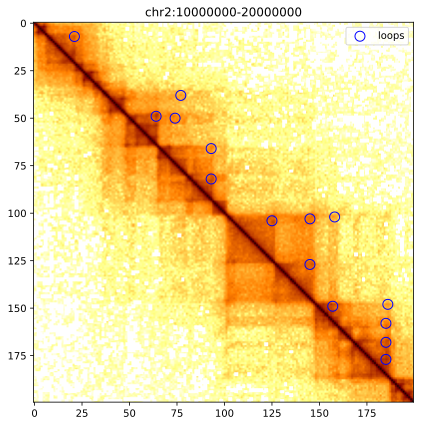

In [113]:
#look at them
%config InlineBackend.figure_format = 'svg'
import re
import json
import numpy as np
import pandas as pd
import cooler
import matplotlib.pyplot as plt
import chromosight.utils.detection as cud

loops = pd.read_csv('/tank/projects/kriukov_chromatin/HIC/loops/combined_KO_down_50000.tsv', sep='\t')
c = cooler.Cooler("/tank/projects/kriukov_chromatin/HIC/downsampled/merged/combined_KO_down_50000.cool")

def subset_region(df, region):
    """
    Given a pattern dataframe and UCSC region string, retrieve only patterns in that region.
    """
    # Split the region string at each occurence of - or : (yields 3 elements)
    chrom, start, end = re.split('[-:]', region)
    start, end = int(start), int(end)
    # Only keep patterns on the same chromosome as the region and
    # within the start-end interval
    subset = df.loc[
        (df.chrom1 == chrom) &
        (df.chrom2 == chrom) &
        (df.start1 >= start) &
        (df.start2 >= start) &
        (df.end1 < end) &
        (df.end2 < end), :
    ]
    return subset

# Select a region of interest

start = 10000000
#region = 'chr2:%d-%d' % (start, start + 3000000)
region = 'chr2:%d-%d' % (start, start + 10_000_000)
mat = c.matrix(sparse=False, balance=True).fetch(region)


loops_sub = subset_region(loops, region)
#borders_sub = subset_region(borders, region)
#hairpins_sub = subset_region(hairpins, region)

# Make genome-based bin numbers relative to the region
for df in [loops_sub]:#, borders_sub, hairpins_sub]:
    df.bin1 -= c.extent(region)[0]
    df.bin2 -= c.extent(region)[0]

%matplotlib inline
plt.figure(figsize=(7, 7))
plt.imshow(np.log10(mat), cmap='afmhot_r')
plt.title(region)
plt.scatter(loops_sub.bin2, loops_sub.bin1, edgecolors='blue', facecolors='none', label='loops', s=100)
#plt.scatter(borders_sub.bin2, borders_sub.bin1, c='lightblue', label='borders')
#plt.scatter(hairpins_sub.bin2, hairpins_sub.bin1, c='green', label='hairpins')
plt.legend()
plt.show()

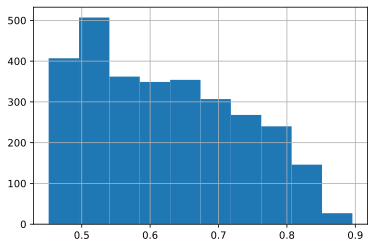

In [114]:
loops.score.hist()

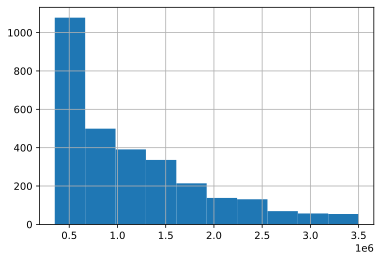

In [115]:
(loops['start2'] - loops['start1']).hist()

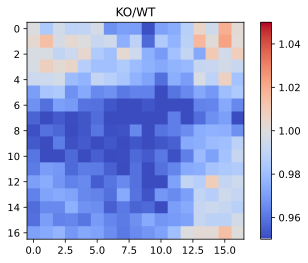

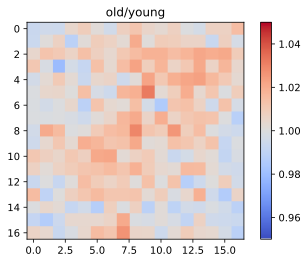

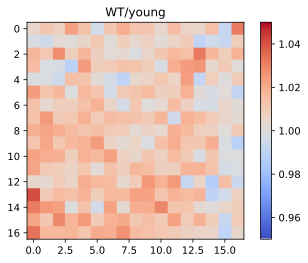

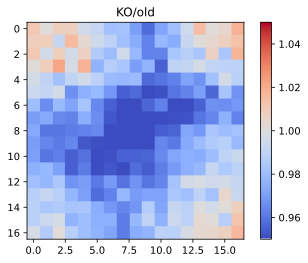

In [135]:
#compare between conditions
LOOPS_WIN_FILES = glob('/tank/projects/kriukov_chromatin/HIC/loops/*_50000.json')

average_loops = {}
for loop_file in LOOPS_WIN_FILES:
    # Load input json file into a dictionary
    loop_wins = json.load(open(loop_file, 'r'))
    # Note that keys are string, as required by the JSON format,
    # so we convert them to int() for convenience
    loop_wins = {int(i): np.array(w) for i, w in loop_wins.items()}
    # Make an empty 3D array of shape N_coords x height x width
    wins = np.zeros((len(loop_wins.items()), *loop_wins[0].shape))
    # Fill the 3D array with windows values
    for i, w in loop_wins.items(): wins[i] = w
    pileup = cud.pileup_patterns(wins)
    name = splitext(basename(loop_file))[0].split('_')[1]
    average_loops[name] = pileup

pairs = [['KO', 'WT'], ['old', 'young'], ['WT', 'young'], ['KO', 'old']]
for pair in pairs:
    divv = average_loops[pair[0]] / average_loops[pair[1]]
    plt.imshow(divv, cmap='coolwarm', vmax=1.05, vmin=0.95)
    plt.title('%s/%s' % (pair[0], pair[1]))
    plt.colorbar()
    plt.show()


# %matplotlib inline
# plt.figure(figsize=(4, 4))
# pileup = cud.pileup_patterns(wins)
# plt.title(basename(loop_file))
# plt.imshow(pileup, cmap='coolwarm', vmax=1.8, vmin=0)
# plt.show()

## ANOVA analysis

In [61]:
explore = ['WT', 'young', 'old']
mask = np.array([any([e in c for e in explore]) for c in IS.columns])

X = IS.drop(IS.columns[~mask], 1).T
X = X.dropna(axis=1)

y = [d.split('_')[0] for d in X.index] #0-for age; 1-for sex

types_dict = {'WT':'Y', 'young':'Y', 'old':'old', 'KO':'KO'}
y = [types_dict[t] for t in y]
print(y)

['Y', 'Y', 'Y', 'old', 'old', 'old', 'Y', 'Y', 'Y']


/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


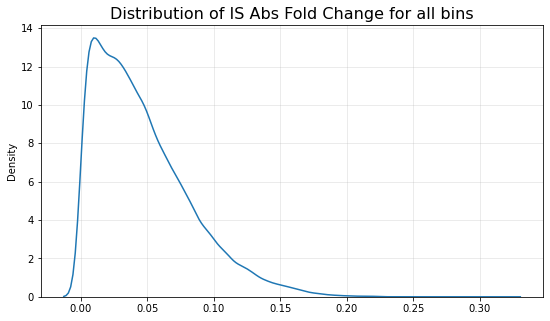

Total number of features: 42953
Number of p_values <= 0.050: 11162
Number of p_values after FDR correction: 4


,14282,14283,14284,35648
WT_female_2,0.444180,0.413791,0.379288,-0.265062
WT_female_3,0.434824,0.409935,0.391529,-0.276402
WT_male_1,0.431056,0.433262,0.423213,-0.249603
old_female_2,0.528548,0.539883,0.520195,-0.067546
old_female_3,0.516813,0.534430,0.513157,-0.106329
old_male_1,0.532389,0.524549,0.528388,-0.079973
young_female_2,0.429855,0.425943,0.393686,-0.286080
young_female_3,0.435138,0.423855,0.405221,-0.250814
young_male_1,0.414353,0.417796,0.401963,-0.292838


In [62]:
anova = ANOVA(X, y, 0.05)
anova.get_filter_distribution('FC')

a, b = anova.make_anova()
anova.get_passed_features()

100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


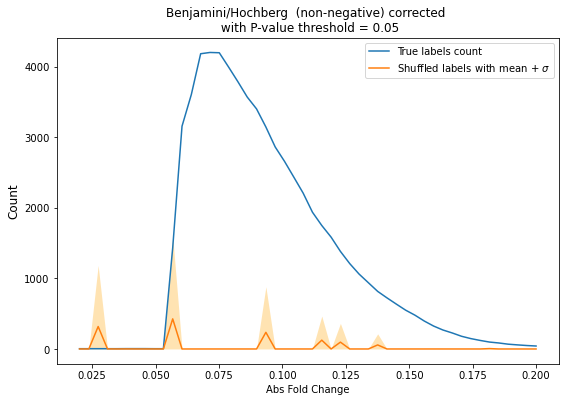

0.07142857142857144

In [63]:
anova.make_permutation_search('FC', interval=(0.02, 0.2), steps=50, N=15, **{'ddof':1})
anova.plot_permutation_results()
anova.get_best_criterion()

In [74]:
X_s, FDR, Pval = anova.get_passed_features_for_some_criterion(criterion=anova.get_best_criterion(), 
                                                        return_pvals=True)
P_adj_s_sorted = np.sort(FDR[1][FDR[0]])
X_s_sorted = X_s.iloc[:, np.argsort(FDR[1][FDR[0]])]

order = ['old', 'Y']
X_group = X_s_sorted.groupby(y).mean()
X_diff = X_group.loc[order[0]] - X_group.loc[order[1]]
#extract intervals and p_values, take top N bins
X_passed_intervals = IS.loc[X_s_sorted.columns][['chrom', 'start', 'end']]
X_passed_intervals['pval'] = Pval[FDR[0]]
X_passed_intervals['p_adj'] = P_adj_s_sorted
X_passed_intervals['FC'] = X_diff

print("Bins passed: %d" % X_passed_intervals.shape[0])

Bins passed: 4202


In [138]:
top = max(500, X_passed_intervals.shape[0])
X_top = X_passed_intervals.sort_values('pval').iloc[:top, :]

#intersection with genes
significant_genes = bins_to_genes_intersection(X_top[['chrom', 'start', 'end']], gn_code)

In [139]:
genesFC = significant_genes.merge(X_top, 
                    left_on=['Chromosome', 'Start_b', 'End_b'], 
                    right_on=['chrom', 'start', 'end'])[['chrom', 'Start', 'End', 'Start_b', 'End_b', 'Name', 'pval', 'FC']]

gmean = lambda x: np.exp(np.mean(np.log(x)))
agg = genesFC.groupby(['Name']).agg({'Start':'first','End':'first', 
                                     'Start_b':'first', 'End_b':'last', 
                                     'pval':gmean, 'FC':'mean'})
agg['p_adj'] = fdr_correction(agg['pval'], alpha=0.05, method='fdr_bh')[1]
agg['ES'] = -np.log10(agg['pval']) * agg['FC']

In [143]:
agg.to_csv('subdata/IS_results.csv')

In [136]:
#Assumptions:
# - Equal variances (sample sizes)
# - Normal distribution of population
# - Independence
EXPLORES = [['old', 'young'], ['KO', 'young'], ['WT', 'young'], ['KO', 'WT'], ['old', 'WT']]
gmean = lambda x: np.exp(np.mean(np.log(x)))

for explore in tqdm(EXPLORES):
    ### Data filtering
    fname = '::'.join(explore)
    mask = np.array([any([e in c for e in explore]) for c in IS.columns])
    X = IS.drop(IS.columns[~mask], 1).T
    X = X.dropna(axis=1)
    y = [d.split('_')[0] for d in X.index] #0-for age; 1-for sex
    
    ### ANOVA
    anova = ANOVA(X, y, 0.02)
    p, pcor = anova.make_anova()
    X_group = X.groupby(y).mean()
    X_diff = X_group.loc[explore[0]] - X_group.loc[explore[1]]
    #extract intervals and p_values, take top N bins
    X_passed_intervals = IS.loc[X.columns][['chrom', 'start', 'end']]
    X_passed_intervals['pval'] = p
    X_passed_intervals['FC'] = X_diff
   
    # #anova.make_permutation_search('FC', interval=(0.02, 0.2), steps=50, N=15, **{'ddof':1})
    # X_s, P_s = anova.get_passed_features_for_some_criterion(criterion=anova.get_best_criterion(), 
    #                                                         return_pvals=True)
    # #plot
    # #anova.plot_permutation_results(savename='Insulation/' + fname + '_FC.png')
    
    # P_adj_s_sorted = np.sort(P_s[1][P_s[0]])
    # X_s_sorted = X_s.iloc[:, np.argsort(P_s[1][P_s[0]])]
    
    #extract intervals and p_values, take top N bins
    # X_passed_intervals = IS_info.loc[X_s_sorted.columns][['chrom', 'start', 'end']]
    # X_passed_intervals['p_adj'] = P_adj_s_sorted
    # X_top = X_passed_intervals.iloc[:top, :]
    
    # #intersection with genes
    significant_genes = bins_to_genes_intersection(X_passed_intervals[['chrom', 'start', 'end']], gn_code)
    genesFC = significant_genes.merge(X_passed_intervals, 
                    left_on=['Chromosome', 'Start_b', 'End_b'], 
                    right_on=['chrom', 'start', 'end'])[['chrom', 'Start', 'End', 'Start_b', 'End_b', 'Name', 'pval', 'FC']]

    agg = genesFC.groupby(['Name']).agg({'Start':'first','End':'first', 
                                        'Start_b':'first', 'End_b':'last', 
                                        'pval':gmean, 'FC':'mean'})
    agg['p_adj'] = fdr_correction(agg['pval'], alpha=0.05, method='fdr_bh')[1]
    agg['ES'] = -np.log10(agg['pval']) * agg['FC'] * (-1) # corresponds to "openness"
    #break
    # print('Found %d genes in top %d bins' % (len(significant_genes), top))
    agg.to_csv('subdata/IS_results_%s.csv' % (fname))

  0%|          | 0/5 [00:00<?, ?it/s]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 1917
Number of p_values after FDR correction: 0


 20%|██        | 1/5 [00:04<00:19,  4.94s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 7735
Number of p_values after FDR correction: 1


 40%|████      | 2/5 [00:09<00:14,  4.85s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 927
Number of p_values after FDR correction: 0


 60%|██████    | 3/5 [00:14<00:09,  4.87s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 10050
Number of p_values after FDR correction: 0


 80%|████████  | 4/5 [00:19<00:04,  4.84s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 3842
Number of p_values after FDR correction: 1


100%|██████████| 5/5 [00:24<00:00,  4.82s/it]


In [137]:
ko = pd.read_csv('subdata/IS_results_KO::young.csv', index_col=0)
wt = pd.read_csv('subdata/IS_results_WT::young.csv', index_col=0)
old = pd.read_csv('subdata/IS_results_old::young.csv', index_col=0)
kow = pd.read_csv('subdata/IS_results_KO::WT.csv', index_col=0)
oldw = pd.read_csv('subdata/IS_results_old::WT.csv', index_col=0)

In [138]:
ES = pd.DataFrame()
ES['KO'] = ko['ES']
ES['WT'] = wt['ES']
ES['old'] = old['ES']
ES['KO-W'] = kow['ES']
ES['old-W'] = oldw['ES']

ES.corr()

,KO,WT,old,KO-W,old-W
KO,1.000000,-0.045825,0.357672,0.803011,0.282115
WT,-0.045825,1.000000,-0.056689,-0.477473,-0.649553
old,0.357672,-0.056689,1.000000,0.329940,0.674201
KO-W,0.803011,-0.477473,0.329940,1.000000,0.599089
old-W,0.282115,-0.649553,0.674201,0.599089,1.000000


# ATAC-seq peaks

In [18]:
ATAC.columns[60:60]

Index(['KO_R1.mLb.clN.qval', 'KO_R2.mLb.clN.qval', 'KO_R3.mLb.clN.qval',
       'WT_R1.mLb.clN.qval', 'WT_R2.mLb.clN.qval', 'WT_R3.mLb.clN.qval',
       'old_R1.mLb.clN.qval', 'old_R2.mLb.clN.qval', 'old_R3.mLb.clN.qval',
       'young_R1.mLb.clN.qval', 'young_R2.mLb.clN.qval',
       'young_R3.mLb.clN.qval', 'KO_R1.mLb.clN.pval', 'KO_R2.mLb.clN.pval',
       'KO_R3.mLb.clN.pval', 'WT_R1.mLb.clN.pval', 'WT_R2.mLb.clN.pval',
       'WT_R3.mLb.clN.pval', 'old_R1.mLb.clN.pval', 'old_R2.mLb.clN.pval',
       'old_R3.mLb.clN.pval', 'young_R1.mLb.clN.pval', 'young_R2.mLb.clN.pval',
       'young_R3.mLb.clN.pval', 'KO_R1.mLb.clN.start', 'KO_R2.mLb.clN.start',
       'KO_R3.mLb.clN.start', 'WT_R1.mLb.clN.start', 'WT_R2.mLb.clN.start',
       'WT_R3.mLb.clN.start'],
      dtype='object')

In [25]:
peaks = ATAC[['chr', 'start', 'end', 'num_peaks', 'num_samples',
            'KO_R1.mLb.clN.bool', 'KO_R2.mLb.clN.bool', 'KO_R3.mLb.clN.bool',
            'WT_R1.mLb.clN.bool', 'WT_R2.mLb.clN.bool', 'WT_R3.mLb.clN.bool',
            'old_R1.mLb.clN.bool', 'old_R2.mLb.clN.bool', 'old_R3.mLb.clN.bool',
            'young_R1.mLb.clN.bool', 'young_R2.mLb.clN.bool', 'young_R3.mLb.clN.bool',
            'Distance to TSS','Gene Name']].copy()

In [27]:
peaks['length'] = ATAC['end'] - ATAC['start']
peaks['absTSS'] = np.abs(peaks['Distance to TSS'])

In [31]:
sum(peaks['absTSS'] < 500)

8383

In [19]:
ATAC[['chr', 'start', 'end', 'num_peaks', 'num_samples',
       'KO_R1.mLb.clN.fc', 'KO_R1.mLb.clN.pval', 'KO_R1.mLb.clN.qval', 'KO_R1.mLb.clN.start']]

,chr,start,end,num_peaks,num_samples,KO_R1.mLb.clN.fc,KO_R1.mLb.clN.pval,KO_R1.mLb.clN.qval,KO_R1.mLb.clN.start
0,1,3094953,3095639,7,7,NaN,NaN,NaN,NaN
1,1,3119552,3120933,12,12,4.26111,8.85153,5.84917,3119808
2,1,3195033,3195525,1,1,NaN,NaN,NaN,NaN
3,1,3292392,3293460,7,7,NaN,NaN,NaN,NaN
4,1,3297635,3298319,2,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
68289,Y,90800452,90800758,1,1,NaN,NaN,NaN,NaN
68290,Y,90804811,90805245,5,5,2.99465,6.58547,3.75818,90804845
68291,Y,90807111,90807842,3,3,NaN,NaN,NaN,NaN
68292,Y,90808445,90809289,3,3,NaN,NaN,NaN,NaN


# Expression slopes

In [163]:
gdf = gn_code[['seq_id', 'start', 'end', 'Name', 'length']].merge(
        slopes[['logFC', 'P.Value', 'adj.P.Val', 'symbol']], 
        left_on='Name', right_on='symbol')

In [43]:
gdf = gdf[gdf['length'] < 50_000]

In [74]:
gdf

,seq_id,start,end,Name,length,logFC,P.Value,adj.P.Val,symbol
0,chr1,4976342,5140528,Rgs20,164186,-0.006422,0.000347,0.012605,Rgs20
1,chr1,12762421,12946090,Sulf1,183669,0.006987,0.002054,0.040782,Sulf1
2,chr1,20960772,21009874,Paqr8,49102,-0.009680,0.001908,0.038986,Paqr8
3,chr1,22356196,22845239,Rims1,489043,-0.011791,0.000011,0.000985,Rims1
4,chr1,23801007,23886946,B3gat2,85939,-0.009256,0.000862,0.022941,B3gat2
...,...,...,...,...,...,...,...,...,...
734,chrX,73453089,73472486,G6pdx,19397,0.005559,0.001815,0.037954,G6pdx
735,chrX,95139651,95212159,Msn,72508,0.008841,0.000010,0.000908,Msn
736,chrX,111510223,111544767,Zfp711,34544,-0.010451,0.001365,0.031541,Zfp711
737,chrX,134643441,134648077,Armcx5,4636,0.008770,0.002725,0.049216,Armcx5


In [164]:
intervals = bins_to_genes_intersection(IS[['chrom', 'start', 'end']], gdf, genes_cols=['seq_id', 'start', 'end'])

In [165]:
intervals_pos_exp = intervals[intervals.logFC > 0][['Chromosome', 'Start_b', 'End_b', 'logFC', 'symbol']]
intervals_neg_exp = intervals[intervals.logFC < 0][['Chromosome', 'Start_b', 'End_b', 'logFC', 'symbol']]

intervals_pos_exp = intervals_pos_exp.merge(IS, 
                        left_on=['Chromosome', 'Start_b', 'End_b'], 
                        right_on=['chrom', 'start', 'end']).dropna(0)
intervals_neg_exp = intervals_neg_exp.merge(IS, 
                        left_on=['Chromosome', 'Start_b', 'End_b'], 
                        right_on=['chrom', 'start', 'end']).dropna(0)

igr_pos = intervals_pos_exp.groupby('symbol').mean()
igr_neg = intervals_neg_exp.groupby('symbol').mean()

IS_pos_exp = intervals_pos_exp.filter(regex='young|old|WT')
IS_neg_exp = intervals_neg_exp.filter(regex='young|old|WT')

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  if __name__ == '__main__':


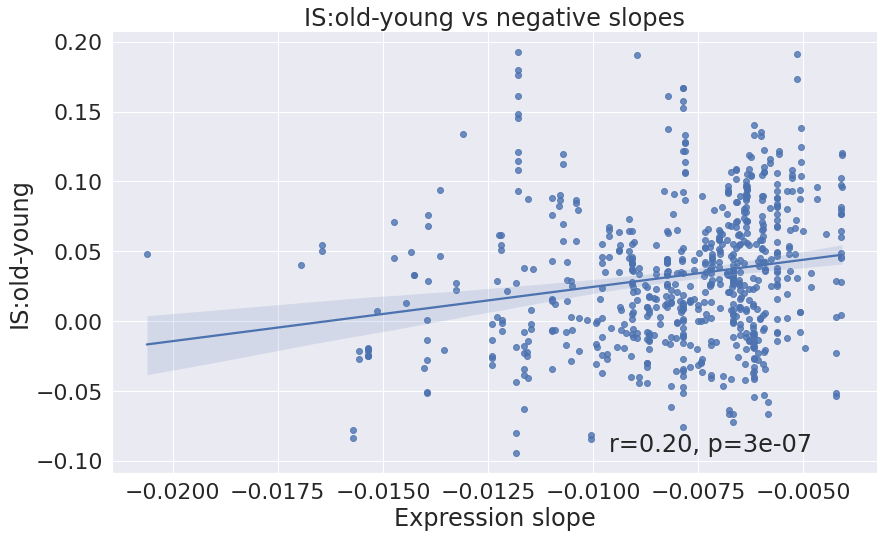

In [169]:
pair = ('old', 'young')
data = intervals_neg_exp#pd.concat([igr_pos, igr_neg])

name = 'IS:' + pair[0] + '-' + pair[1]
data[name] = data.filter(regex=pair[0]).mean(1) -\
                                 data.filter(regex=pair[1]).mean(1)
g = sns.lmplot(y=name, x='logFC', data=data, height=8, aspect=1.6)

def annotate(data, **kws):
    from scipy import stats
    r, p = stats.pearsonr(data['logFC'], data[name],)
    ax = plt.gca()
    ax.text(.65, .05, 'r={:.2f}, p={:.2g}'.format(r, p), transform=ax.transAxes)
    ax.set_xlabel('Expression slope')
    ax.set_title(name + ' vs negative slopes')
    
g.map_dataframe(annotate)

In [47]:
intervals_pos_exp.filter(regex='young|old|WT|logFC').corr()['logFC']

logFC             1.000000
WT_female_2       0.086776
WT_female_3       0.079786
WT_male_1         0.075279
old_female_2      0.052280
old_female_3      0.069355
old_male_1        0.069479
young_female_2    0.083711
young_female_3    0.068609
young_male_1      0.079183
Name: logFC, dtype: float64

,WT_female_2,WT_female_3,WT_male_1,old_female_2,old_female_3,old_male_1,young_female_2,young_female_3,young_male_1
0,-0.806333,-0.842055,-0.817961,-0.691018,-0.759715,-0.640139,-0.755641,-0.807805,-0.809376
1,-0.626262,-0.668269,-0.647708,-0.513928,-0.540383,-0.470029,-0.590704,-0.650991,-0.662328
2,-0.504817,-0.561608,-0.488090,-0.415732,-0.382548,-0.386714,-0.504710,-0.563001,-0.543770
3,-0.052845,-0.060989,0.021204,0.145004,0.080595,0.157167,0.064980,-0.025441,-0.053260
4,-0.203414,-0.152278,-0.106975,0.006436,-0.093497,-0.015023,-0.097459,-0.113723,-0.174998
...,...,...,...,...,...,...,...,...,...
655,0.505243,0.402812,0.579525,0.528635,0.455875,0.636435,0.477128,0.522878,0.639246
656,-0.644127,-0.488210,-0.684240,-0.540200,-0.612783,-0.736987,-0.602273,-0.535458,-0.745974
657,-0.084974,-0.152249,-0.185904,-0.176514,-0.155930,-0.128187,-0.133215,-0.116486,-0.183581
658,-0.181401,-0.155343,-0.262898,-0.248209,-0.185560,-0.174989,-0.212963,-0.186797,-0.286330


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.155e-07 U_stat=1.305e+06
young v.s. WT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.223e-02 U_stat=1.528e+06
young v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.246e-02 U_stat=1.374e+06


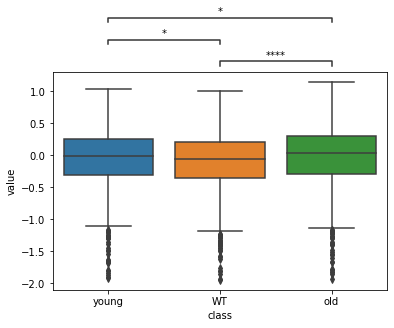

In [49]:
from statannot import add_stat_annotation

tmp = pd.melt(IS_pos_exp)
tmp['class'] = tmp.variable.apply(lambda x: x.split('_')[0])

x = "class"
y = "value"
order = ['young', 'WT', 'old']
ax = sns.boxplot(data=tmp, x=x, y=y, order=order)
test_results = add_stat_annotation(ax, data=tmp, x=x, y=y, order=order,
                                   box_pairs=[("old", "WT"), ("WT", "young"), ('old', 'young')],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.202e-01 U_stat=1.460e+05
young v.s. WT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.603e+05
young v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.506e+05


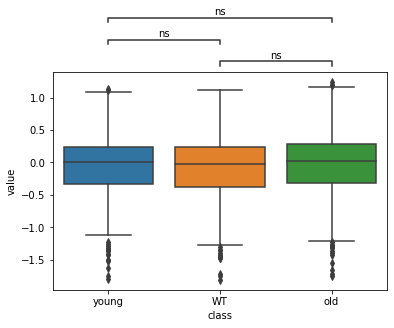

In [50]:
tmp = pd.melt(IS_neg_exp)
tmp['class'] = tmp.variable.apply(lambda x: x.split('_')[0])

x = "class"
y = "value"
order = ['young', 'WT', 'old']
ax = sns.boxplot(data=tmp, x=x, y=y, order=order)
test_results = add_stat_annotation(ax, data=tmp, x=x, y=y, order=order,
                                   box_pairs=[("old", "WT"), ("WT", "young"), ('old', 'young')],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)